# NewsGuard: проверка новостей на фейк
Датасет, который я использовал для обучения модели - [ссылка](https://www.kaggle.com/datasets/bhavikjikadara/fake-news-detection)

In [64]:
import re
from pathlib import Path

import pandas as pd

In [65]:
RDF_PATH = Path("./data/true.csv")  # real data frame
FDF_PATH = Path("./data/fake.csv")  # fake data frame

SVC_W_PATH = Path("./weights/svc_model.pkl")  # Путь сохранения весов SVC
CATBOOST_W_PATH = Path("./weights/catboost_model.cbm")  # Путь сохранения весов CATBOOST
PYTORCH_W_PATH = Path("./weights/pytorch.pth")  # Путь сохранения весов pytorch

# Подгружаем датасеты

In [66]:
rdf = pd.read_csv(RDF_PATH)
rdf.head()  # посмотрим реальные новости

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [67]:
fdf = pd.read_csv(FDF_PATH)
fdf.head()  # посмотрим фейковые новости

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


### Базовая информация о датасете РЕАЛЬНЫХ новостей

In [68]:
rdf.isna().sum()  # посмотрим количество потерянных данных

title      0
text       0
subject    0
date       0
dtype: int64

In [69]:
rdf.info()  # посмотрим общую информацию о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


Все колонки имеют тип строки. Дату нужно будет преобразовать с помощью datetime

### Базовая информация о датасете ФЕЙК новостей

In [70]:
fdf.isna().sum()  # посмотрим количество потерянных данных

title      0
text       0
subject    0
date       0
dtype: int64

In [71]:
fdf.info()  # посмотрим общую информацию о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


Все колонки имеют тип строки. Дату нужно будет преобразовать с помощью datetime

# Предобработка 

## Общее

In [72]:
def check_duplicates(corpus: pd.Series):
    """
    Проверка наличия дубликатов
    """
    duplicate = corpus.value_counts()[corpus.value_counts() > 1]
    return duplicate.rename_axis("unique_values").reset_index(name="counts")


## Реальные новости

### Проверка и удаление дубликатов

In [73]:
# Выводим найденные дубликаты и их количество
duplicates = check_duplicates(rdf["text"])
print("ОБЩЕЕ КОЛИЧЕСТВО ДУБЛИКАТОВ - ", duplicates.shape[0])
print(duplicates)

# Удаляем дубликаты
rdf = rdf.drop_duplicates(subset=["text"], ignore_index=True)

ОБЩЕЕ КОЛИЧЕСТВО ДУБЛИКАТОВ -  212
                                         unique_values  counts
0    (Reuters) - Highlights for U.S. President Dona...       8
1    (Reuters) - Highlights for U.S. President Dona...       5
2    (Reuters) - Highlights of the day for U.S. Pre...       5
3    (Reuters) - Highlights for U.S. President Dona...       3
4    BANGKOK (Reuters) - Thailand on Wednesday mark...       2
..                                                 ...     ...
207  BRUSSELS (Reuters) - The EU executive launched...       2
208  (Reuters) - U.S. President Donald Trump ramped...       2
209  WARSAW (Reuters) - Polish President Andrzej Du...       2
210  UNITED NATIONS (Reuters) - The 193-member Unit...       2
211  MEXICO CITY (Reuters) - The driver of a tour b...       2

[212 rows x 2 columns]


In [74]:
print("После удаления дубликатов, осталось ", rdf.shape[0], " строк данных")

После удаления дубликатов, осталось  21192  строк данных


### Предобработка времени

In [75]:
from datetime import datetime

dates = []

for x in rdf["date"]:
    date = datetime.strptime(x, "%B %d, %Y ")
    dates.append(date)

rdf["date"] = dates

In [76]:
rdf.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29


## Фейковые новости

### Проверка и удаление дубликатов и пустых статей

In [77]:
# Выводим найденные дубликаты и их количество
duplicates = check_duplicates(fdf["text"])
print("ОБЩЕЕ КОЛИЧЕСТВО ДУБЛИКАТОВ - ", duplicates.shape[0])
print(duplicates)


ОБЩЕЕ КОЛИЧЕСТВО ДУБЛИКАТОВ -  4928
                                          unique_values  counts
0                                                           626
1     Things didn t go as well as Nicholle had hoped...       4
2     On September 15, Hillary  apparently  held a r...       4
3     AP News  The regulars amble in before dawn and...       4
4                                                             4
...                                                 ...     ...
4923   Shawn Helton  21st Century WireOrlando s Puls...       2
4924  Just when you thought the 2014 election result...       2
4925  This is why we cannot do deals with Democrats ...       2
4926  21st Century Wire says It s called    Tykables...       2
4927  The children were greeted at the Capitol steps...       2

[4928 rows x 2 columns]


In [78]:
# Удаляем строки с пустыми текстами
blank = fdf.loc[fdf["text"] == duplicates["unique_values"][0]]
print("Количество записей без текста: ", blank.shape[0])
fdf = fdf.drop(blank.index)
print("После удаления пустых записей, осталось ", fdf.shape[0], " строк данных.")

Количество записей без текста:  626
После удаления пустых записей, осталось  22855  строк данных.


In [79]:
# Удаляем дубликаты
fdf = fdf.drop_duplicates(subset=["text"], ignore_index=True)
print("После удаления всех дубликатов, осталось ", fdf.shape[0], " строк данных.")

После удаления всех дубликатов, осталось  17454  строк данных.


### Предобработка времени

In [80]:
dates = []
for x in fdf["date"]:
    try:
        date = datetime.strptime(x, "%B %d, %Y")
    except ValueError:
        try:
            date = datetime.strptime(x, "%d-%b-%y")
        except ValueError:
            try:
                date = datetime.strptime(x, "%b %d, %Y")
            except ValueError:
                print(f"Не удается обработать значение: {x}")


Не удается обработать значение: https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/
Не удается обработать значение: https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/
Не удается обработать значение: https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/
Не удается обработать значение: https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg
Не удается обработать значение: https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg
Не удается обработать значение: MSNBC HOST Rudely Assumes Steel Worker Would Never Let His Son Follow in His Footsteps…He Couldn’t Be More Wrong [Video]


В коде выше обнаруживается, что в фейковых новостях находится что-то интересное. \
Что-то, что не преобразовывается в формат даты. Будем разбираться... \
Как вариант, такие значения можно отследить по аномальной длине.

In [81]:
fdf["date_len"] = [len(x) for x in fdf["date"]]
print(fdf["date_len"].nlargest(20))

15121    149
9357     145
16127    120
15120     88
15423     74
15424     66
285       18
286       18
287       18
288       18
289       18
290       18
291       18
292       18
293       18
294       18
295       18
296       18
297       18
298       18
Name: date_len, dtype: int64


In [82]:
##==> Получаем плохие данные
##################################################
bad_date = fdf.loc[fdf["date_len"] > 18]
bad_date

,title,text,subject,date,date_len
9357,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,145
15120,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,https://100percentfedup.com/video-hillary-aske...,88
15121,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,https://100percentfedup.com/12-yr-old-black-co...,149
15423,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,74
15424,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,66
16127,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,left-news,MSNBC HOST Rudely Assumes Steel Worker Would N...,120


In [83]:
fdf = fdf.drop(index=bad_date.index)  # дропаем плохие значения
fdf = fdf.drop("date_len", axis=1)  # дропаем вспомогательную колонку

In [84]:
##==> Ещё раз пытаемся преобразовать значения в даты
#####################################################
dates = []

for x in fdf["date"]:
    try:
        date = datetime.strptime(x, "%B %d, %Y")
    except ValueError:
        try:
            date = datetime.strptime(x, "%d-%b-%y")
        except ValueError:
            date = datetime.strptime(x, "%b %d, %Y")

    dates.append(date)

fdf["date"] = dates

In [85]:
fdf.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25


## Общее

In [86]:
# Добавляем целевую метрику
rdf["isFake"] = 0
fdf["isFake"] = 1

In [87]:
dataset = pd.concat([rdf, fdf]).reset_index(drop=True)  # Объединяем датасеты

In [88]:
# Объединяем название и текст статьи в одну переменную
dataset["article"] = dataset["title"] + ". " + dataset["text"]

# Удаляем прошлые колонки
dataset = dataset.drop(["title", "text"], axis=1)
dataset.head()

,subject,date,isFake,article
0,politicsNews,2017-12-31,0,"As U.S. budget fight looms, Republicans flip t..."
1,politicsNews,2017-12-29,0,U.S. military to accept transgender recruits o...
2,politicsNews,2017-12-31,0,Senior U.S. Republican senator: 'Let Mr. Muell...
3,politicsNews,2017-12-30,0,FBI Russia probe helped by Australian diplomat...
4,politicsNews,2017-12-29,0,Trump wants Postal Service to charge 'much mor...


In [89]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

##==> Подгружаем стоп слова
####################################################
nltk.download("stopwords")
stopwords = list(set(stopwords.words("english")))


stemmer = PorterStemmer()  # инициализируем стеммер для снижения вариативности слов

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dimflix/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [90]:
def clean_text(text):
    # Приводим текст к нижнему регистру и удаляем нежелательные символы
    text = text.lower()
    text = re.sub(r"[\d#@]|https?://\S+|<!--.*?-->", "", text)  # Удаляем цифры, хештеги, ссылки и HTML-теги
    text = re.sub(r"[^\w\s]", "", text)  # Удаляем пунктуацию

    # Преобразуем стоп-слова в множество для ускорения поиска
    stopwords_set = set(stopwords)

    # Удаляем стоп-слова и применяем стемминг
    cleaned_words = [stemmer.stem(word) for word in text.split() if word not in stopwords_set]

    return " ".join(cleaned_words)

In [91]:
dataset["cleaned_article"] = dataset["article"].apply(clean_text)  # чистим статьи от мусора
dataset.head()

,subject,date,isFake,article,cleaned_article
0,politicsNews,2017-12-31,0,"As U.S. budget fight looms, Republicans flip t...",us budget fight loom republican flip fiscal sc...
1,politicsNews,2017-12-29,0,U.S. military to accept transgender recruits o...,us militari accept transgend recruit monday pe...
2,politicsNews,2017-12-31,0,Senior U.S. Republican senator: 'Let Mr. Muell...,senior us republican senat let mr mueller job ...
3,politicsNews,2017-12-30,0,FBI Russia probe helped by Australian diplomat...,fbi russia probe help australian diplomat tipo...
4,politicsNews,2017-12-29,0,Trump wants Postal Service to charge 'much mor...,trump want postal servic charg much amazon shi...


# Более глубокий анализ

In [92]:
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

In [93]:
def top_n_words(corpus: pd.Series, n: int = 10) -> pd.DataFrame:
    """Функция для получение топ N слов"""
    words_list = []
    for article in corpus.str.split():
        words_list.extend([word for word in article])

    # подсчет вхождений слов
    word_counts = Counter(words_list)

    # Получаем уникальные слова и их количество
    unique_words = list(word_counts.keys())
    counts = list(word_counts.values())

    df_counts = pd.DataFrame({"word": unique_words, "occurences": counts})
    top_words_df = df_counts.sort_values(by="occurences", ascending=False).head(n)
    return top_words_df

In [94]:
##==> Выводим топ 10 слов из реальных статей
#################################################
top_words_rdf = top_n_words(dataset[dataset["isFake"] == False]["cleaned_article"])  # noqa: E712
top_words_rdf

,word,occurences
100,said,97805
68,trump,59118
0,us,44625
135,state,36972
132,would,31369
66,presid,28655
9,reuter,28141
4,republican,22924
105,govern,20323
124,year,19237


In [95]:
##==> Выводим топ 10 слов из фейк статей
#################################################
top_words_fdf = top_n_words(dataset[dataset["isFake"] == True]["cleaned_article"])  # noqa: E712
top_words_fdf

,word,occurences
1,trump,71312
247,said,23060
38,presid,21945
86,peopl,21125
26,one,18715
72,would,18337
253,state,17529
52,like,17344
95,say,16699
0,donald,15624


На основе анализа можно предположить, что наличие большого количества имен собственных и эмоционально окрашенных слов может быть индикатором фейковых новостей. \
В то время как частое использование нейтральных терминов может свидетельствовать о достоверности источника.

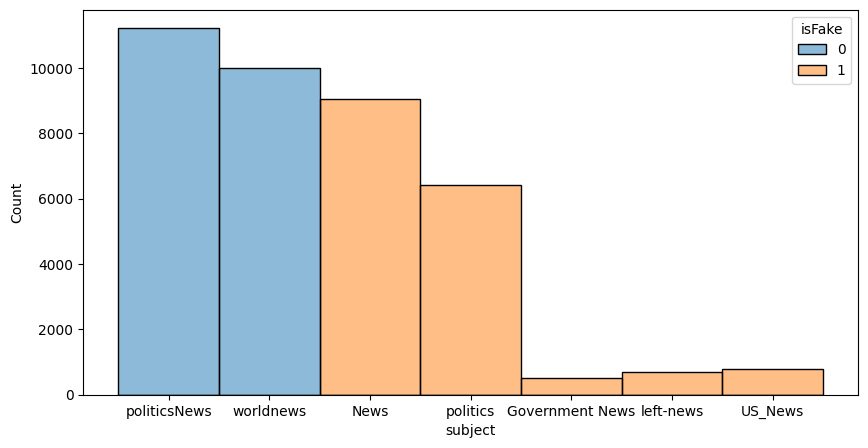

In [96]:
##==> Смотрим распределение тем статей, при этом различая данные по категориальной переменной isFake
#######################################################################################################
fig, hist = plt.subplots(figsize=(10, 5))
hist = sns.histplot(data=dataset, x="subject", hue="isFake")

Если мы посмотрим на данный график, то увидим, что темы новостей не пересекаются у реальных и фейковых новостей, \
что даст возможность модели думать о том, что фейк зависит напрямую от темы. Если у статьи тема не politicNews или worldnews, то это фейк. \
Нам такого не надо, поэтому при обучении моделей мы не будем учитывать этот параметр.

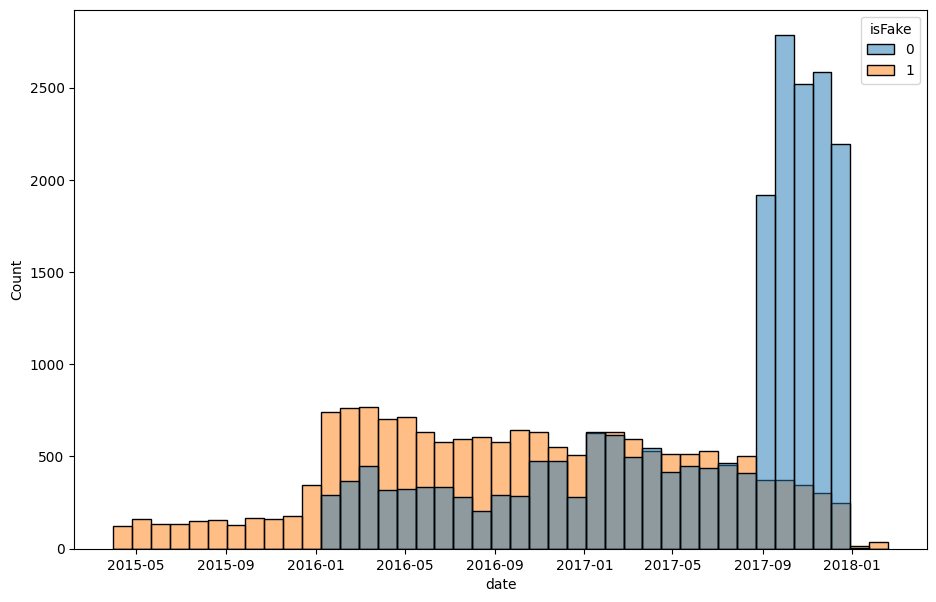

In [97]:
##==> Смотрим распределение дат выпуска статей, при этом различая данные по категориальной переменной isFake
###############################################################################################################
fig, hist = plt.subplots(figsize=(11, 7))
hist = sns.histplot(data=dataset, x="date", hue="isFake")

Распределение дат проверенных и фейковых статей отличается. \
Фейки активно появлялись до 2016, а начиная с 2017-09 по 2018-01 были реальные статьи.

Модель может подумать, что фейковые статьи бывают только в период с 2015-05 по 2017-09, \
поэтому в обучении мы не будем учитывать даты выхода статей.

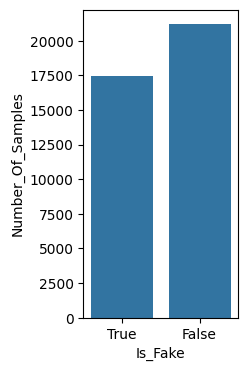

In [100]:
# определения баланса реальных и фейковых новостей
nb_true = dataset["isFake"].sum()
nb_false = len(dataset["isFake"]) - nb_true
distrib = pd.DataFrame(
    data=dict(Number_Of_Samples=[nb_true, nb_false], Is_Fake=["True", "False"])
)
fig, bar = plt.subplots(figsize=(2, 4))
bar = sns.barplot(y="Number_Of_Samples", x="Is_Fake", data=distrib);

Среднее значение между всеми фейковыми и реальными новостями сбалансировано. \
Смело можем переходить к обучению моделек ->

# Обучение

In [101]:
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [102]:
##==> Разделяем датасет на выборки
#############################################
X = dataset["cleaned_article"]
y = dataset["isFake"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [103]:
##==> Выделяем наиболее значимые слова в текстах с помощью TF-IDF
######################################################################
# Создаем векторизатор с использованием TF-IDF, исключая английские стоп-слова
vectorizer = TfidfVectorizer(stop_words="english")

# Обучаем векторизатор на тренировочных данных и преобразуем их в матрицу TF-IDF
X_train = vectorizer.fit_transform(X_train)

# Применяем тот же векторизатор к тестовым данным для получения матрицы TF-IDF
X_test = vectorizer.transform(X_test)

## SVC

In [104]:
from sklearn.svm import SVC

In [105]:
# Создаем модель Support Vector Classifier
svc_model = SVC(kernel="linear")

# Обучаем модель на тренировочных данных
svc_model.fit(X_train, y_train)

SVC(kernel='linear')

In [106]:
svc_predictions = svc_model.predict(X_test)  # проверяем модель на тестовых данных

In [107]:
print("SVC Accuracy:", round(accuracy_score(y_test, svc_predictions) * 100, 4), "%")

SVC Accuracy: 99.1201 %


In [108]:
print("SVC Classification Report:")
print(classification_report(y_test, svc_predictions))

SVC Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4210
           1       0.99      0.99      0.99      3518

    accuracy                           0.99      7728
   macro avg       0.99      0.99      0.99      7728
weighted avg       0.99      0.99      0.99      7728



In [109]:
# сохраняем веса
joblib.dump(svc_model, SVC_W_PATH)

['weights/svc_model.pkl']

## CatBoost

In [110]:
from catboost import CatBoostClassifier

In [111]:
# Создаем модель CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=1000, learning_rate=0.1, depth=6, verbose=100
)

# Обучаем модель на тренировочных данных
catboost_model.fit(X_train, y_train)

0:	learn: 0.4978431	total: 465ms	remaining: 7m 44s
100:	learn: 0.0202596	total: 20.5s	remaining: 3m 2s
200:	learn: 0.0138390	total: 40.5s	remaining: 2m 41s
300:	learn: 0.0105618	total: 1m	remaining: 2m 20s
400:	learn: 0.0079706	total: 1m 20s	remaining: 1m 59s
500:	learn: 0.0063906	total: 1m 39s	remaining: 1m 39s
600:	learn: 0.0055274	total: 1m 59s	remaining: 1m 19s
700:	learn: 0.0050121	total: 2m 18s	remaining: 59.2s
800:	learn: 0.0048607	total: 2m 38s	remaining: 39.4s
900:	learn: 0.0048107	total: 2m 58s	remaining: 19.6s
999:	learn: 0.0045847	total: 3m 18s	remaining: 0us


In [112]:
catboost_predictions = catboost_model.predict(X_test)  # проверяем модель на тестовых данных

In [113]:
print(
    "CatBoost Accuracy:", round(accuracy_score(y_test, catboost_predictions) * 100, 4), "%"
)

SVC Accuracy: 99.5083 %


In [114]:
print("CatBoost Classification Report:")
print(classification_report(y_test, catboost_predictions))

CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4210
           1       1.00      0.99      0.99      3518

    accuracy                           1.00      7728
   macro avg       1.00      0.99      1.00      7728
weighted avg       1.00      1.00      1.00      7728



In [115]:
# сохраняем веса
catboost_model.save_model(CATBOOST_W_PATH)

## Нейронная сеть на PyTorch

In [116]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [117]:
class NewsDataset(Dataset):
    def __init__(self, articles, labels):
        self.articles = articles
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        article_tensor = torch.tensor(
            self.articles[idx].toarray(), dtype=torch.float32
        )  # преобразуем статьи в тензоры pytorch
        label_tensor = torch.tensor(
            self.labels[idx], dtype=torch.float32
        )  # преобразуем метки в тензоры pytorch
        return article_tensor, label_tensor

In [118]:
# Наборы данных для PyTorch DataLoader
train_dataset = NewsDataset(X_train, y_train.values)
test_dataset = NewsDataset(X_test, y_test.values)

# Даталоадеры для итерации по данным
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [119]:
class FakeNewsClassifier(nn.Module):
    def __init__(self):
        super(FakeNewsClassifier, self).__init__()
        self.fc1 = nn.Linear(
            X_train.shape[1], 128
        )  # Входной слой - скрытый слой (128 нейронов)
        self.fc2 = nn.Linear(128, 64)  # Скрытый слой - скрытый слой (64 нейрона)
        self.fc3 = nn.Linear(
            64, 1
        )  # Скрытый слой - выходной слой (1 нейрон для бинарной классификации)
        self.sigmoid = nn.Sigmoid()  # Сигмоидальная активация для бинарной классификации (для получения вероятности принадлежности к классу)

    def forward(self, x):
        """
        Функция определяет прямое распространение данных через сеть.
        """
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [120]:
model = FakeNewsClassifier()
criterion = nn.BCELoss()  # для бинарной классификации
optimizer = optim.Adam(
    model.parameters(), lr=0.001
)  # алгоритм оптимизации для обновления параметров модели во время обучения.

In [121]:
# обучаем
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    for articles, labels in train_loader:
        # разбиваем тренировочные данные на батчи (пакеты) для более эффективного обучения
        optimizer.zero_grad()
        outputs = model(articles).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/5], Loss: 0.0138
Epoch [2/5], Loss: 0.0049
Epoch [3/5], Loss: 0.0000
Epoch [4/5], Loss: 0.0000
Epoch [5/5], Loss: 0.0000


In [122]:
# сохраняем веса
torch.save(model.state_dict(), PYTORCH_W_PATH)

In [123]:
# Переводим модель в режим оценки
model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []

    for articles, labels in test_loader:
        outputs = model(articles).squeeze()
        predicted_labels = (outputs > 0.5).float()

        y_true.extend(labels.numpy())
        y_pred.extend(predicted_labels.numpy())

In [124]:
print("PyTorch NN Accuracy:", round(accuracy_score(y_true, y_pred) * 100, 4), "%")

SVC Accuracy: 98.9648 %


In [125]:
print("Neural Network Classification Report:")
print(classification_report(y_true, y_pred))

Neural Network Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      4210
         1.0       0.99      0.99      0.99      3518

    accuracy                           0.99      7728
   macro avg       0.99      0.99      0.99      7728
weighted avg       0.99      0.99      0.99      7728



# Итоги

Итак, я считаю, что мне удалось обучить три довольно неплохие модели для определения фейковых новостей. \
Все они показали очень хорошие результаты. \
Конечно-же, если сравнивать их между собой, то **лучшая из них - CatBoost с метрикой Accuracy - 99.5083 %**